# Split the dataset into train val

In [26]:
import splitfolders # or import splitfolders
input_folder = "/home/kolapally/code/kolapally/computer_vision/data/faces"
output = "/home/kolapally/code/kolapally/computer_vision/data" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 171 files [00:00, 6674.29 files/s]


# data augmentation

In [1]:
import os
import pandas as pd
import shutil
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_dataframe(sdir):
    # sdir is the directory when the class subdirectories are stored
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    # return a dataframe with columns filepaths, labels
    return df

def make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg'):
    #augdir is the full path where augmented images will be stored
    #n is the number of augmented images that will be created for each class that has less than n image samples
    # img_size  is a tupple(height,width) that specifies the size of the augmented images
    # color_mode is 'rgb by default'
    # save_prefix is the prefix augmented images are identified with by default it is 'aug-'
    #save_format is the format augmented images will be save in, by default it is 'jpg'
    # see documentation of ImageDataGenerator at https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for details
    df=df.copy()        
    if os.path.isdir(augdir):# start with an empty directory
        shutil.rmtree(augdir)
    os.mkdir(augdir)  # if directory does not exist create it      
    for label in df['labels'].unique():    
        classpath=os.path.join(augdir,label)    
        os.mkdir(classpath) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    # in ImageDateGenerator select the types of augmentation you desire  below are some examples  
    gen=ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        classdir=os.path.join(augdir, label)
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create            
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=classdir, save_prefix=save_prefix, color_mode=color_mode,
                                            save_format=save_format)
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count        
    print('Total Augmented images created= ', total)

2023-03-27 18:20:03.875425: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
sdir=r'/home/kolapally/code/kolapally/computer_vision/data/train'
df=make_dataframe(sdir)
print (df.head())
print ('length of dataframe is ',len(df))

augdir=r'/home/kolapally/code/kolapally/computer_vision/data/Aug' # directory to store the images if it does not exist it will be created
n=1500# if the class had N image samples in the sdir, if N<n than in augdir n-N augmented images will be created 
img_size=(128,128) # image size (height,width) of augmented images
make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg')

Pam                      : 100%|████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 63151.38files/s]

                                           filepaths  labels
0  /home/kolapally/code/kolapally/computer_vision...  Angela
1  /home/kolapally/code/kolapally/computer_vision...  Angela
2  /home/kolapally/code/kolapally/computer_vision...  Angela
3  /home/kolapally/code/kolapally/computer_vision...  Angela
4  /home/kolapally/code/kolapally/computer_vision...  Angela
length of dataframe is  135
Found 21 validated image filenames.      for class             Angela             creating 1479  augmented images 


Found 21 validated image filenames.      for class             Dwight             creating 1479  augmented images 
Found 24 validated image filenames.      for class              Jim               creating 1476  augmented images 
Found 23 validated image filenames.      for class             Kevin              creating 1477  augmented images 
Found 22 validated image filenames.      for class            Michael             creating 1478  augmented images 
Found 24 validated image filenames.      for class              Pam               creating 1476  augmented images 
Total Augmented images created=  8865


# imagedataset from dictionary

In [1]:
from  tensorflow.keras.utils import image_dataset_from_directory

2023-03-30 01:05:24.903682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 01:05:26.053436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 01:05:26.053704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-30 01:05:26.168711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-30 01:05:28.811730: W tensorflow/stream_executor/platform/de

In [10]:
images_train = image_dataset_from_directory(
                                             directory = '/home/daniel/code/dosorio79/code/kolapally/computer_vision/notebooks/DSO_model_tests/efficientnet/Aug',
                                                    batch_size=32,
                                                   labels = 'inferred',
                                                   label_mode='categorical',
#       class_names=['Angela','Dwight','Jim','Kevin','Michael','Pam'],
                                                    image_size = (128,128),
                                                    seed = 42,
                                                    validation_split = 0.001,
                                                      subset = 'training',
                                                   interpolation = 'area',
                                                     crop_to_aspect_ratio = True)

Found 8865 files belonging to 6 classes.
Using 8857 files for training.


In [3]:
images_val = image_dataset_from_directory(
                                             directory = '/home/daniel/code/dosorio79/code/kolapally/computer_vision/notebooks/DSO_model_tests/efficientnet/val',
                                                    batch_size=32,
                                                   labels = 'inferred',
                                                   label_mode='categorical',
#       class_names=['Angela','Dwight','Jim','Kevin','Michael','Pam'],
                                                    image_size = (128,128),
                                                    seed = 42,
                                                    validation_split = 0.99,
                                                      subset = 'validation',
                                                   interpolation = 'area',
                                                     crop_to_aspect_ratio = True)

Found 36 files belonging to 6 classes.
Using 35 files for validation.


In [6]:
class_names = images_train.class_names

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

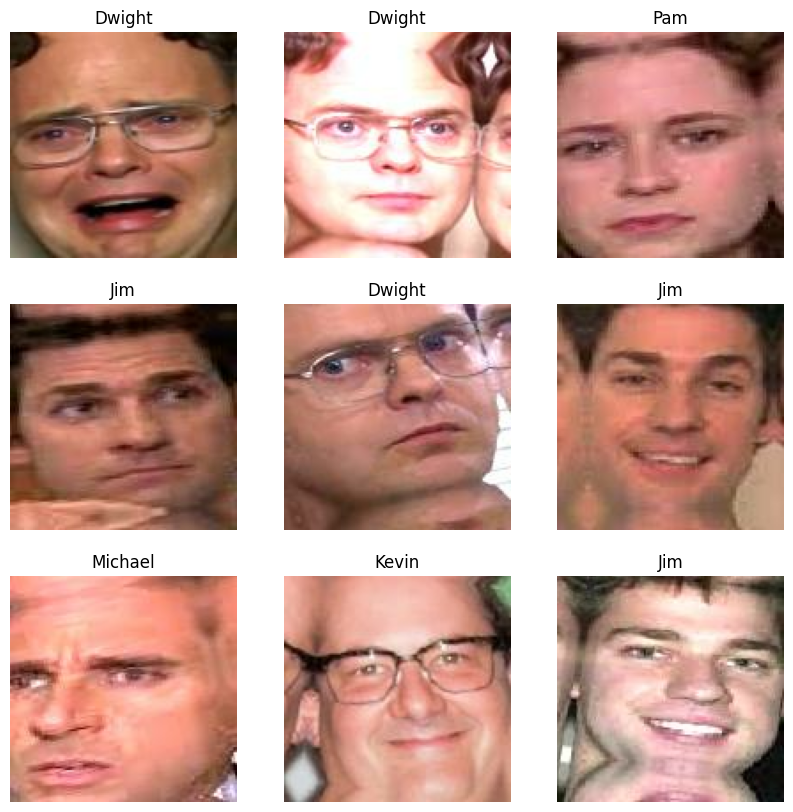

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in images_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


# model with EffcientnetV2

In [4]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications import ResNet50

In [5]:
base_model = EfficientNetV2L(input_shape = (128,128,3), include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained VGG16 model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 4, 4, 1280)       117746848 
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 512)               10486272  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                        

In [8]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.002)

# Compile the model with the new optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights=True)

In [11]:
history = model.fit(images_train,
                  epochs = 150,
                  batch_size=32,
                  verbose=1,
                  validation_data=images_val,
                  callbacks = [es]
              )

Epoch 1/150
277/277 [==============================] - 772s 3s/step - loss: 0.4824 - accuracy: 0.9015 - val_loss: 0.5134 - val_accuracy: 0.9143
Epoch 2/150
277/277 [==============================] - 672s 2s/step - loss: 0.0964 - accuracy: 0.9685 - val_loss: 0.5443 - val_accuracy: 0.8857
Epoch 3/150
277/277 [==============================] - 661s 2s/step - loss: 0.1077 - accuracy: 0.9738 - val_loss: 0.6868 - val_accuracy: 0.8857
Epoch 4/150
277/277 [==============================] - 668s 2s/step - loss: 0.0901 - accuracy: 0.9773 - val_loss: 0.5011 - val_accuracy: 0.9429
Epoch 5/150
277/277 [==============================] - 673s 2s/step - loss: 0.0598 - accuracy: 0.9878 - val_loss: 0.9506 - val_accuracy: 0.9143
Epoch 6/150
277/277 [==============================] - 672s 2s/step - loss: 0.0514 - accuracy: 0.9892 - val_loss: 0.8998 - val_accuracy: 0.8571
Epoch 7/150
277/277 [==============================] - 670s 2s/step - loss: 0.0448 - accuracy: 0.9890 - val_loss: 0.7752 - val_accuracy:

In [12]:
model.save('model-efficientV2L_batch32_300323.h5')

In [26]:
base_model1 = ResNet50(input_shape = (128,128,3), include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model1.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained VGG16 model
model1 = Sequential([
    base_model1,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

In [27]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 40,498,310
Trainable params: 16,910,598


In [28]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.003)

# Compile the model with the new optimizer
model1.compile(loss='categorical_crossentropy',
              optimizer=adam_optimizer,
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience = 15, restore_best_weights=True)

In [34]:
history1 = model1.fit(images_train,
                  epochs = 100,
                  batch_size=128,
                  verbose=1,
                  validation_data=images_val,
                  callbacks = [es]
              )

Epoch 1/100
70/70 [==============================] - 216s 3s/step - loss: 14.1765 - accuracy: 0.6854 - val_loss: 1.4130 - val_accuracy: 0.7429
Epoch 2/100
70/70 [==============================] - 207s 3s/step - loss: 0.0610 - accuracy: 0.9785 - val_loss: 0.9396 - val_accuracy: 0.8286
Epoch 3/100
70/70 [==============================] - 229s 3s/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 1.0513 - val_accuracy: 0.8286
Epoch 4/100
70/70 [==============================] - 226s 3s/step - loss: 0.0117 - accuracy: 0.9960 - val_loss: 0.9801 - val_accuracy: 0.8286
Epoch 5/100
70/70 [==============================] - 210s 3s/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 1.0613 - val_accuracy: 0.8286
Epoch 6/100
70/70 [==============================] - 211s 3s/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.8936 - val_accuracy: 0.8286
Epoch 7/100
70/70 [==============================] - 216s 3s/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 1.0350 - val_accuracy: 0.7714
Epoch